In [1]:
# model architecture modified from https://keras.io/examples/vision/mnist_convnet/

In [2]:
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Lambda, Softmax, Dense
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Convert y_train into one-hot format
temp = []
for i in range(len(y_train)):
    temp.append(to_categorical(y_train[i], num_classes=10))
y_train = np.array(temp)
# Convert y_test into one-hot format
temp = []
for i in range(len(y_test)):    
    temp.append(to_categorical(y_test[i], num_classes=10))
y_test = np.array(temp)

In [5]:
#reshaping
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [6]:
inputs = Input(shape=(28,28,1))
out = Lambda(lambda x: x/1000)(inputs)
out = Conv2D(4, 3)(out)
out = Lambda(lambda x: x**2+x)(out)
out = AveragePooling2D()(out)
out = Lambda(lambda x: x*4)(out)
out = Conv2D(8, 3)(out)
out = Lambda(lambda x: x**2+x)(out)
out = AveragePooling2D()(out)
out = Lambda(lambda x: x*4)(out)
out = Flatten()(out)
out = Dense(10, activation=None)(out)
out = Softmax()(out)
full_model = Model(inputs, out)

In [7]:
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 4)         40        
_________________________________________________________________
lambda_1 (Lambda)            (None, 26, 26, 4)         0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 4)         0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 8)         296   

In [8]:
full_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
    )

In [9]:
full_model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/15
469/469 [==============================] - 7s 13ms/step - loss: 1.0953 - acc: 0.6511 - val_loss: 0.1934 - val_acc: 0.9440
Epoch 2/15
469/469 [==============================] - 6s 13ms/step - loss: 0.1778 - acc: 0.9481 - val_loss: 0.1139 - val_acc: 0.9649
Epoch 3/15
469/469 [==============================] - 6s 13ms/step - loss: 0.1173 - acc: 0.9655 - val_loss: 0.0996 - val_acc: 0.9706
Epoch 4/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0951 - acc: 0.9721 - val_loss: 0.0798 - val_acc: 0.9750
Epoch 5/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0857 - acc: 0.9740 - val_loss: 0.0703 - val_acc: 0.9781
Epoch 6/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0789 - acc: 0.9762 - val_loss: 0.0759 - val_acc: 0.9769
Epoch 7/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0717 - acc: 0.9778 - val_loss: 0.0680 - val_acc: 0.9789
Epoch 8/15
469/469 [==============================] - 6s 13ms/step - 

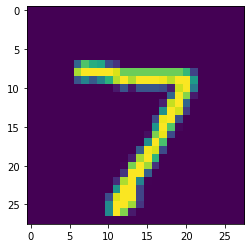

In [10]:
X = X_test[[0]]
plt.imshow(X[0])

In [11]:
model = Model(full_model.input, full_model.layers[-2].output)

In [12]:
y = model.predict(X) - model.weights[5].numpy()
y

array([[ -2.4457285,   1.4092684,   5.032708 ,   7.488841 , -10.394337 ,
         -1.645153 , -25.219566 ,  21.458466 ,  -5.5855045,   1.6345799]],
      dtype=float32)

In [13]:
print(len(model.weights))
for weights in model.weights:
    print(weights.shape)

6
(3, 3, 1, 4)
(4,)
(3, 3, 4, 8)
(8,)
(200, 10)
(10,)


In [14]:
in_json = {
    "in": X.astype(int).flatten().tolist(), # X is already 1000 times to begin with
    "conv2d_1_weights": (model.weights[0].numpy()*(10**3)).round().astype(int).flatten().tolist(),
    "conv2d_1_bias": (model.weights[1].numpy()*(10**3)*(10**3)).round().astype(int).flatten().tolist(),
    # poly layer would be (10**3)**2=10**6 times as well
    "conv2d_2_weights": (model.weights[2].numpy()*(10**3)).round().astype(int).flatten().tolist(),
    "conv2d_2_bias": (model.weights[3].numpy()*((10**3)**5)).round().astype(int).flatten().tolist(),
    # poly layer would be (10**3)**5=10**15 times as well
    "dense_weights":(model.weights[4].numpy()*(10**3)).round().astype(int).flatten().tolist(),
    "dense_bias": np.zeros(model.weights[5].numpy().shape).tolist() # zero because we are not doing softmax in circom, just argmax
}

In [15]:
out_json = {
    "scale": 10**-33,
    "out": y.flatten().tolist(),
    "label": int(y_test[0].argmax())
}
out_json

{'scale': 1e-33,
 'out': [-2.4457285404205322,
  1.4092683792114258,
  5.032708168029785,
  7.4888410568237305,
  -10.394336700439453,
  -1.6451530456542969,
  -25.219566345214844,
  21.458465576171875,
  -5.585504531860352,
  1.6345798969268799],
 'label': 7}

In [16]:
import json

In [17]:
with open("mnist_convnet_input.json", "w") as f:
    json.dump(in_json, f)

In [18]:
with open("mnist_convnet_output.json", "w") as f:
    json.dump(out_json, f)